In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("hw5.ipynb")

---

<h1><center>SDSE Homework 5<br><br> Time series forecasting </center></h1>

---

In this homework you will apply time series forecasting methods to the problem of predicting demands for a large power grid. The data comes from [PJM](https://www.pjm.com/about-pjm), a regional transmission organization covering a large portion of the east coast of the United States. Specifically, the data is for northern Illinois. It contains hourly values of electricity demand (in MW) between 2004 and 2010. 

The homeworks consists of these parts:

+ Load the data
+ Split the data into training, validation, and testing datasets
+ Normalize the data
+ Organize the data into input sequences and output values
+ Train these models
    + Linear regression
    + Multi-layer perceptron (a.k.a. dense neural network)
    + simple RNN
    + LSTM
+ Compare the models
+ Compute performance of the selected model

In [2]:
# NOTE: If you are running this in JupyterLab, you will have to do the following:
# + Run this cell. This will install tensorflow in your JupyterLab environment.
# + Comment out the code in this cell, to prevent an unnecessary re-install.
# + Restart your kernel (Kernel>Restart kernel...)

# %pip install --upgrade pip
# %pip install "numpy<1.24"
# %pip install --upgrade tensorflow==2.16.2

In [3]:
# Do not modify this cell
import os
import random
import numpy as np
import pandas as pd
from pandas.core.indexes.datetimes import DatetimeIndex
import matplotlib.pyplot as plt
import tensorflow
from hashutils import *
os.environ['PYTHONHASHSEED'] = '0'  # optional, for hash-based functions
random.seed(2434)
np.random.seed(2434)
tensorflow.random.set_seed(2434)
tensorflow.keras.utils.set_random_seed(2434)
tensorflow.config.experimental.enable_op_determinism()
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
np.set_printoptions(precision=4)

2025-05-02 16:29:00.103672: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### 0. Load the data into a pandas DataFrame

The data is contained in a csv file called `demand.csv`. Load this file into a pandas DataFrame using `read_csv` with the following input arguments:
+ index_col=[0]. The first column in the csv file contains the time stamp. This tells pandas to use this as the index of the data frame.
+ parse_dates=[0]. This tells pandas to convert the time stamps into DateTime objects.

Keep the DataFrame in a variable called `raw_data`.

**Note**: This part has already been completed.

In [4]:
raw_data = pd.read_csv('demand.csv', index_col=[0], parse_dates=[0])

# Display the first 5 rows of the dataset
raw_data.head()

,power demand [MW]
Datetime,
2004-05-01 01:00:00,9198.0
2004-05-01 02:00:00,8570.0
2004-05-01 03:00:00,8183.0
2004-05-01 04:00:00,7917.0
2004-05-01 05:00:00,7828.0


### Plot the full time series

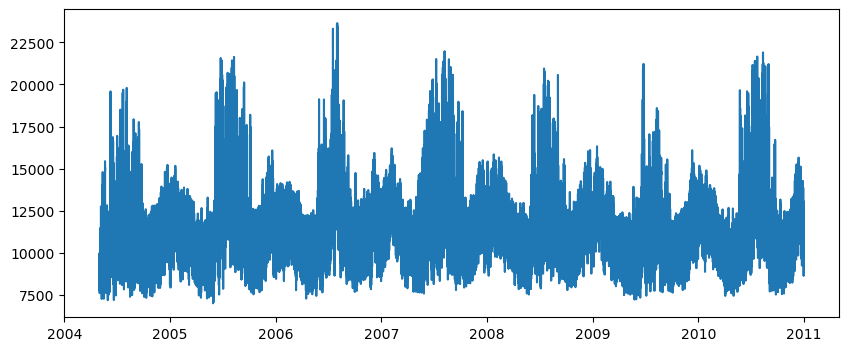

In [5]:
plt.figure(figsize=(10,4))
plt.plot(raw_data)

### 1. Split the data into training, validation, and testing datasets

Write a function called `split_data` that takes these arguments:
+ `pt`: A number between 0 and 1 corresponding to the proportion of the data to be used for *training*.
+ `pv`: A number between 0 and 1 corresponding to the proportion of the data to be used for *validation*. Validation here means that it will be used by the fitting function of the neural network to evaluate the model at each step of stochastic gradient descent. 

The function should return 3 pandas DataFrames: `data_train`, `data_validate`, and `data_test` (in that order). 

Each of these should contain a **copy** of the segment of `raw_data` that will be used for training, validation, and testing respectively. 

The length of `data_train` should be the integer part of `N*pt`, where `N` is the total number of samples in `raw_data`. Similarly for `data_validate`.

**Notes**:
+ `raw_data` is not passed to `split_data` because it is a global variable.
+ Training data should precede validation data in time. 
+ Validation data should precede testing data in time.

**Hint**:
+ [DataFrame.copy](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.copy.html)


In [6]:
def split_data(pt,pv):

    assert(pt>=0)
    assert(pv>=0)
    assert(pt+pv<=1)

    data = raw_data.copy()

    data_train = data[0:int(data.shape[0]*pt)]
    data_validate = data[int(data.shape[0]*pt):int(data.shape[0]*(pt+pv))]
    data_test = data[int(data.shape[0]*(pt+pv)):]
    
    return data_train, data_validate, data_test

In [7]:
# test your code:
data_train, data_validate, data_test = split_data(0.5, 0.3)
#data_train.tail()
# data_validate.head()
# data_validate.tail()
# data_test.tail()
raw_data.tail()

,power demand [MW]
Datetime,
2010-12-31 20:00:00,11585.0
2010-12-31 21:00:00,11243.0
2010-12-31 22:00:00,10825.0
2010-12-31 23:00:00,10511.0
2011-01-01 00:00:00,10042.0


In [8]:
grader.check("q1")

q1 results: All test cases passed!

### 2. Split the data

Use your `split_data` function to split the data with the following proportions:
+ `data_train`, with %70 of the data,
+ `data_validate`, with %10 of the data,
+ `data_test`, with %20 of the data.

In [9]:
# The grader for q2 marks correct differently

def split_data(pt,pv):

    assert(pt>=0)
    assert(pv>=0)
    assert(pt+pv<=1)

    data = raw_data.copy()

    data_train = data[0:int(data.shape[0]*pt)]
    data_validate = data[int(data.shape[0]*pt):int((data.shape[0]*(pt+pv))+1)]
    data_test = data[int((data.shape[0]*(pt+pv)+1)):]
    
    return data_train, data_validate, data_test

In [10]:
data_train, data_validate, data_test = split_data(0.7, 0.1)

In [11]:
grader.check("q2")

q2 results: All test cases passed!

### Plot the training, validation, and test data.

Done already.

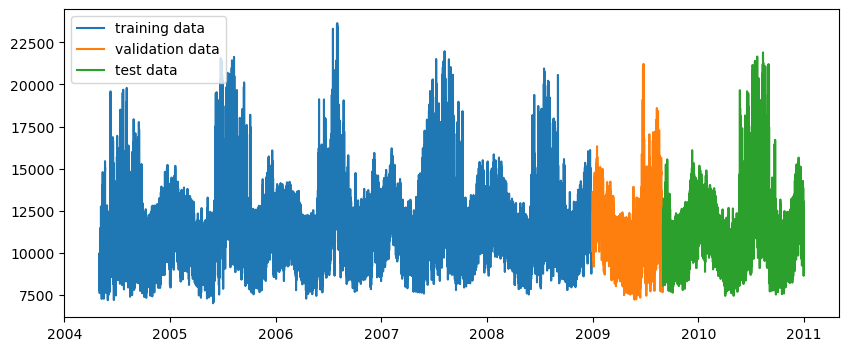

In [12]:
plt.figure(figsize=(10,4))
plt.plot(data_train,label='training data')
plt.plot(data_validate,label='validation data')
plt.plot(data_test,label='test data')
plt.legend()

### 3. Normalize the data

Use ScikitLearn's `StandardScaler` to normalize the data. Normalizing a dataset, as we've seen, means subtracting its mean and dividing by its standard deviation. This can improve the performance of certain "scale-dependent" models, such as neural networks. (decision trees are scale-*independent*)

Follow these steps:
1. Create a `StandardScaler` object. You can name it whatever you like (e.g. "scaler").
2. Pass the training data (`data_train`) to its `fit` method. This will compute and store the mean and standard deviation of the training sequence. 
3. Apply the scaling transformation to the training sequence by passing it to the scaler's `transform` method. Save the result in a column called `"scaled"` in the training data DataFrame (`data_train`). 
4. Do the same for `data_validate` and `data_test`.

After doing this, `data_train` should look like this:

<img src="df.png" width=350 />

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data_train['scaled'] = scaler.fit_transform(data_train)[:, 0]
data_validate['scaled'] = scaler.transform(data_validate)[:, 0]
data_test['scaled'] = scaler.transform(data_test)[:, 0]

In [14]:
grader.check("q3")

q3 results: All test cases passed!

### Plot the scaled training, validation, and test data. 

Done already.

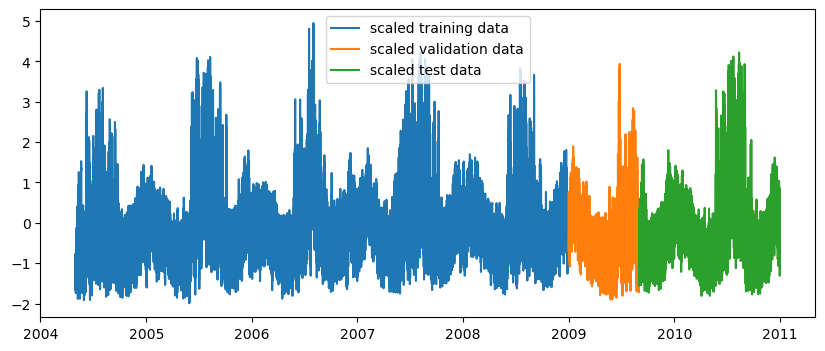

In [15]:
plt.figure(figsize=(10,4))
plt.plot(data_train['scaled'],label='scaled training data')
plt.plot(data_validate['scaled'],label='scaled validation data')
plt.plot(data_test['scaled'],label='scaled test data')
plt.legend()

### 4. Organize the data into input and output sequences

Our goal is to build a model that can forecast the power demand $F$ hours in the future using the $T$ most recent hourly values. To train this model we must organize the training sequence into an input matrix $\mathbf{X}$ and output column vector $\mathbf{Y}$. With $N$ denoting the length of the training sequence (in our case $N=40,915$, as you can verify), the number of rows in $\mathbf{X}$ will be 
$$N' = N-F-T+1$$
The number of columns in $\mathbf{X}$ is $T$.

Write a function called `organize_data` that takes these arguments:
+ `d`: a pandas Series object such as `data_train['scaled']`. 
+ `T`: $T$ as described above.
+ `F`: $F$ as described above.

The function should return the following:
+ `X`, a 2D NumPy array with $N'$ rows and $T$ columns containing the matrix $\mathbf{X}$.
+ `Y`, a 1D NumPy array with $N'$ entries containing the vector $\mathbf{Y}$.
+ `t`, a 1D NumPy array with timestamps for each sample. Each timestamp is a `DatetimeIndex` object.

The two figures below illustrate the organization of $\mathbf{t}$, $\mathbf{X}$, and $\mathbf{Y}$. The first figure shows three input/output samples (green, orange, and blue). The inputs are the sequences of length $T=14$. For example, the green input sequence is collected at 5:00 PM, and it consists of hourly data starting at 4:00 AM. The output of the model is trained to match the forecasted green point at 8:00 PM. 

Similarly, the orange sample consists of an input sequence, collected at 6:00 PM and consisting of  14 hourly values from 5:00 AM to 6:00 PM, and used to predict a value at 9:00 PM.

<img src="samples.png" width=800 />


These samples are arranged into arrays $\mathbf{t}$, $\mathbf{X}$, and $\mathbf{Y}$ as shown below. Notice that the timestamp $\mathbf{t}$ corresponds to the time at which the prediction is made, which is also the time at which the left-most column of $\mathbf{X}$ is measured. For example, the time stamp for the green sample is 5:00 PM.


<img src="snipets.png" width=700 />



In [104]:
def organize_data(d,F,T):

    N = d.shape[0]
    Np = N - F - T + 1
    X = np.empty((Np,T))
    Y = np.empty(Np)
    t = np.empty(Np,dtype=DatetimeIndex)

    # Fill in X, Y, and t
    for row in range(Np):
        X[row] = d.iloc[row:row+T]
        Y[row] = d.iloc[row+T+F-1]
        t[row] = d.index[row+T]
        
    return X, Y, t

In [105]:
grader.check("q4")

q4 results: All test cases passed!

### 5. Call `organize_data` on the training, validation, and test data

We wish to predict the power demand $F=12$ hours in the future from the $T=6$ most recent values. Use `organize_data` to assemble $\mathbf{X}$ and $\mathbf{Y}$ arrays for the **scaled** training, validation, and test data. 

Call these:
+ `Xtrain` and `ytrain` for the training data.
+ `Xvalid` and `yvalid` for the validation data.
+ `Xtest` and `ytest` for the test data.

In [106]:
T = 6
F = 12
Xtrain, ytrain, ttrain = organize_data(data_train['scaled'], F, T)
Xvalid, yvalid, tvalid = organize_data(data_validate['scaled'], F, T)
Xtest, ytest, ttest = organize_data(data_test['scaled'], F, T)

In [107]:
grader.check("q5")

q5 results: All test cases passed!

### Plot the individual sequences

The plot below shows a few sequences in `Xtrain`, jiggled by a small amount so that they do not overlap.

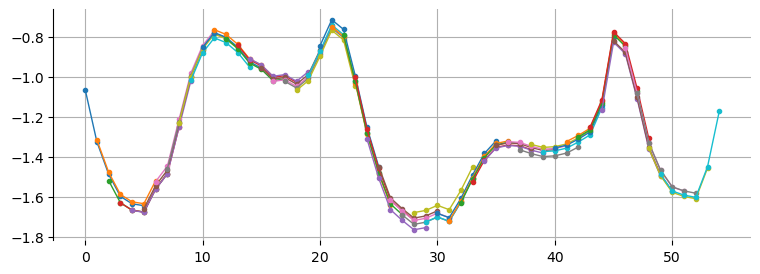

In [108]:
fig, ax = plt.subplots(figsize=(9,3))
for i in range(50):
    ax.plot(range(i,i+T),Xtrain[i,:]+np.random.normal(scale=0.02),marker='.',linewidth=1)
ax.spines[['top','right','bottom']].set_visible(False)
ax.grid()

### 6. Linear regression

Train a Scikit-learn linear regression model using `Xtrain` and `ytrain`. 
+ Do not pass any arguments to the `LinearRegression` constructor. 
+ Save the trained model in the variable `linreg`.


In [109]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression().fit(Xtrain, ytrain)

In [110]:
grader.check("q6")

q6 results: All test cases passed!

### 7. Performance relative to a baseline model

Let's decide on a performance metric to use. 

Consider the coefficient of determination, $R^2$: 
$$ R^2 = 1 - \frac{\sum(\hat{y}_i-y_i)^2}{\sum(\hat{y}_i-\bar{y})^2}$$
This metric compares the MSE of a model to that of a "baseline" prediction $\bar{y}$, which is simply the mean of the training outputs $\{y_i\}_N$. This makes sense for iid data, but it is too simplistic for time series data. A better baseline for the forecasting problem is to predict that *the future is the same as the present*. In other words, we predict that the value of the power demand in $F$ hours will be the same as the current value. This is illustrated in the figure below for $T=3$ and $F=6$.

<img src="baseline.png" width=700 /> 

The mean absolute error of the model is given by,

$$\text{MAE(model)} = \frac{1}{N'} \sum_{k} \left( |x_{k+F}-\hat{y}_k| \right)    $$

The baseline mean absolute error of the model is,

$$\text{MAE(baseline)} = \frac{1}{N'} \sum_{k} \left( |x_{k+F}-x_k| \right)    $$


The performance of the model is then obtained, analogously to $R^2$ by comparing the MAE of the model to the baseline MAE:

$$ \text{Performance(model)} = 1 - \frac{\text{MAE(model)}}{\text{MAE(baseline)}}$$

Note that the baseline performance is 0, while a "perfect" model (with zero MAE) would have a performance of 1. Better models have larger values of performance.

Write a function called `assess` that implements this performance metric. The function should take these input arguments:
+ `x_current`: a NumPy array with the *current* values of power demand ($x_k$ above). 
+ `y`: a NumPy array with the true future values of power demand ($y_k$ above). 
+ `yhat`: a NumPy array with the model predictions ($\hat{y}_k$ above). 

**Hint**
+ To compute the performance of the linear regression model on the validation data we would run

```python 
assess( x_current = Xtrain[:,-1],
        y = ytrain,
        yhat = linreg.predict(Xtrain))
```

In [ ]:
from sklearn.metrics import mean_absolute_error

def assess(x_current,y,yhat):
    ...
    perf = ...
    return perf

In [ ]:
print(f'Performance of linear regression on the training data: {assess(Xtrain[:,-1],ytrain,linreg.predict(Xtrain)):.4f}')
print(f'Performance of linear regression on the validation data: {assess(Xvalid[:,-1],yvalid,linreg.predict(Xvalid)):.4f}')

In [ ]:
grader.check("q7")

### 8. Include hour-of-day

Our linear regression model is performing only about 30\% closer to "perfect prediction" than the baseline model. Let's see if we can improve it.

 We know that demand for electricity is more or less periodic over a day. Hence, hour-of-day may be a useful input to include in the model. To test this idea, we must first write a function that appends the hour-of-day as a final (right-most) column in our input matrix $\mathbf{X}$. 

Write a function called `append_hour_of_day` that takes these input arguments: 
+ `X`: A 2D NumPy array of input sequences, such as `Xtrain`, `Xvalid`, or `Xtest`.
+ `t`: A 1D NumPy array of time stamps, such as `ttrain`, `tvalid`, or `ttest`.

The function should return a new 2D NumPy array with `X` as its first $T$ columns, and the *hour-of-the-day* in its last column.  The hour-of-the-day is an integer between 0 and 23 inclusive. It is stored as the `hour` attribute of each element in `t`, e.g. `ttrain[0].hour`.

**Hint**:

+ Running `append_hour_of_day(Xtrain,ttrain)` should return an array whose first 5 rows are:

<img src="xtrainhour.png" width=600 /> 



In [ ]:
def append_hour_of_day(X,t):
    ...
    return ...

In [ ]:
# test your code
Xtrain_hour = append_hour_of_day(Xtrain,ttrain)
Xtrain_hour[:5,:]

In [ ]:
grader.check("q8")

### 9. Include hour-of-day in training, validation, and test data

Run your `append_hour_of_day` on the training, validation, and test data. Store the results as 
`Xtrain_hour`, `Xvalid_hour`, and `Xtest_hour` respectively.

In [ ]:
...

In [ ]:
grader.check("q9")

### 10. New linear regression with hour-of-day

Train a new linear regression model using the input matrix that includes hour-of-day. Save the fitted model as `linreg_hour`.

Compute the performance of both linear regression models on the validation data. Save the performance of `linreg` to `linreg_perf`, and of `linreg_hour` to `linreg_hour_perf`. Did the performance improve?

In [ ]:
...

In [ ]:
grader.check("q10")

### 11. Build an MLP 

We will now try several neural network models to see whether they can deliver better performance than linear regression. We begin with a multi-layer perceptron (MLP).

Build a MLP model for the forecast problem with the hour-of-the-day as an additional input. The model should have this sequence of layers:
1. A dense layer with 64 units and ReLU activation.
2. A dense layer with 32 units and ReLU activation.
3. A dense layer with 16 units and ReLU activation.
4. A dense layer with 1 units no activation (this is the output layer).

Each layer should also be passed a `kernel_initalizer`, which is set to a `GlorotUniform` object. This is done for you in this part, but you should add it to neural networks in parts 13 and 14 as well. This is needed to guarantee repeatability of the results. 

Use variable name `model_mlp` for this model.

Compile the model with its `compile` method and these input arguments:
+ `optimizer="rmsprop"`. Tells Keras to use the "root-mean-squared propagation" variant of stochastic gradient descent for training. 
+ `loss="mse"`: Use the L2 loss function. 
+ `metrics=["mae"]`: Record the mean absolute error at the end of each epoch.

**Note**
+ You will have to pass the `input_shape` to the first layer of the MLP. This should be set to `input_shape=(D,)`, where `D` is the number of features in your training data (i.e. in `Xtrain_hour`) 
+ We also have to pass a "kernel initializer" to each of the layers. This determines the manner in which the weights on each of the edges of the neural network are initialized. We use a random seed to ensure that the initialization is the same every time, so that the autograder can work correctly. 

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.initializers import GlorotUniform


ki = GlorotUniform(seed=2434) # This is needed for reproducibility of the results

model_mlp = Sequential([
    Dense(..., input_shape=..., activation=..., kernel_initializer=ki),
    Dense(..., activation=..., kernel_initializer=ki),
    Dense(..., activation=..., kernel_initializer=ki),
    Dense(..., kernel_initializer=ki)
])

model_mlp.compile( ... )

In [ ]:
grader.check("q11")

### 12. Train the MLP

Train your MLP by calling its `fit` function. Use these input arguments:
+ `x=Xtrain_hour`. Use the training data matrix that includes the hour-of-the-day.
+ `y=ytrain`. Training target.
+ `epochs=10`. Train for 10 epochs.
+ `validation_data=(Xvalid_hour,yvalid)`. Pass in the validation data so that Keras can track the MAE of the model.

Save the output of the fit function to the variable name `history_mlp`.

Use the `assess` function to evaluate the performance of your trained model using the validation data.

**Note**
+ We must copy the code from the previous part into this cell, so that the neural network is created and compiled afresh each time before training. This is to ensure reproducibility of the results and proper function of the autograder. 

In [ ]:
random.seed(2434)  # Do not change this. It is needed to ensure repeatability.


### Copy your code from the previous part here ####

###################################################

history_mlp = model_mlp.fit(...)

print('Validation: ',assess(Xvalid[:,-1],yvalid,model_mlp.predict(Xvalid_hour)))

In [ ]:
grader.check("q12")

### Plot the training history for MLP

In [ ]:
num_epochs = len(history_mlp.epoch)
plt.figure(figsize=(9,3))
plt.plot(range(num_epochs), history_mlp.history["mae"],marker='o', label="Training MAE")
plt.plot(range(num_epochs), history_mlp.history["val_mae"],marker='o', label="Validation MAE")
plt.xlabel('epoch')
plt.title("Training of MLP")
plt.legend()

### 13. Build and train a SimpleRNN

Next, create a neural network with simple RNN units. The model should have this sequence of layers:
1. A SimpleRNN layer with **32** units. Because this is the first layer of the neural netork, we must define the shape of the input. Set `input_shape=(D,1)`. Also, with recurrent layers that feed into downstream recurrent layers, we need to pass `return_sequences=True`.
2. A SimpleRNN layer with **32** units. Again pass `return_sequences=True`.
2. A SimpleRNN layer with **16** units. No need to pass `return_sequences=True` in this case because the next downstream layer is dense.
3. A dense layer with **1** unit and no activation (this is the output layer).

**Notes**:
+ Use variable name `model_srnn` for this model.
+ Do not pass an `activation` to any of the SimpleRNN layers.
+ Compile the model with its `compile` method and the same input arguments as in part 11.
+ Train your simple RNN model by calling its `fit` function. Use the same input arguments as in part 12.
+ Save the output of the fit function to the variable name `history_srnn`.
+ Use the `assess` function to evaluate the performance of your trained model using the validation data. 

In [ ]:
from tensorflow.keras.layers import SimpleRNN
random.seed(2434)  # Do not change this. It is needed to ensure repeatability.

model_srnn = ...

print('Validation: ',assess(Xvalid[:,-1],yvalid,model_srnn.predict(Xvalid_hour)))

In [ ]:
grader.check("q13")

### Plot the training history of the Simple RNN

In [ ]:
num_epochs = len(history_srnn.epoch)
plt.figure(figsize=(9,3))
plt.plot(range(num_epochs), history_srnn.history["mae"],marker='o', label="Training MAE")
plt.plot(range(num_epochs), history_srnn.history["val_mae"],marker='o', label="Validation MAE")
plt.xlabel('epoch')
plt.title("Training of Simple RNN")
plt.legend()

### 14. Build and train an LSTM 

Finally, create a neural network with LSTM units. The instructions are identical to those of the simple RNN.

The model should have this sequence of layers:
1. A LSTM layer with **16** units. Because this is the first layer of the neural netork, we must define the shape of the input. Set `input_shape=(D,1)`. Also, with recurrent layers that feed into downstream recurrent layers, we need to pass `return_sequences=True`.
2. A LSTM layer with **16** units. Again pass `return_sequences=True`.
2. A LSTM layer with **8** units. No need to pass pass `return_sequences=True` in this case because the next downstream layer is dense.
3. A dense layer with **1** unit and no activation (this is the output layer).

**Notes**:
+ Use variable name `model_lstm` for this model.
+ Do not pass an `activation` to any of the LSTM layers.
+ Compile the model with its `compile` method and the same input arguments as in part 11.
+ Train your LSTM model by calling its `fit` function. Use the same input arguments as in part 12.
+ Save the output of the fit function to the variable name `history_lstm`.
+ Use the `assess` function to evaluate the performance of your trained model using the validation data. 



In [ ]:
from tensorflow.keras.layers import LSTM
random.seed(2434)  # Do not change this. It is needed to ensure repeatability.

model_lstm = ...

In [ ]:
grader.check("q14")

### Plot the training history of the LSTM

In [ ]:
num_epochs = len(history_lstm.epoch)
plt.figure(figsize=(9,3))
plt.plot(range(num_epochs), history_lstm.history["mae"],marker='o', label="Training MAE")
plt.plot(range(num_epochs), history_lstm.history["val_mae"],marker='o', label="Validation MAE")
plt.xlabel('epoch')
plt.title("Training of LSTM")
plt.legend()

### Single plot with the training histories of our three neural network models

In [ ]:
num_epochs = len(history_lstm.epoch)

plt.figure(figsize=(9,3))
plt.plot(range(num_epochs), history_mlp.history["val_mae"], '.-',markersize=10,label="MLP validation MAE")
plt.plot(range(num_epochs), history_srnn.history["val_mae"], '.-',markersize=10,label="sRNN validation MAE")
plt.plot(range(num_epochs), history_lstm.history["val_mae"], '.-',markersize=10, label="LSTM validation MAE")
plt.title("Validation MAE")
plt.legend()

### 15. Pick the best model

Evaluate the performance of the four models (linear regression with hour-of-day, MLP, simple RNN, and LSTM) using the validation data (again). Store the result in these variable names: 
+ `linreg_hour_perf`
+ `mlp_perf`
+ `srnn_perf`
+ `lstm_perf`

Choose the best one and save it as `best_model`. For example, if the linear regression model were the best one, your would write:
```python 
best_model = linreg_hour
```

In [ ]:
...

In [ ]:
grader.check("q15")

### 16. Final model test performance

Now that we have made a final selection of a model, it is time to use the test dataset. 

Evaluate the performance of `best_model` on the test data. Save the result to the variable `best_perf`.

In [ ]:
...

In [ ]:
grader.check("q16")

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [ ]:
# Save your notebook first, then run this cell to export your submission.
grader.export(pdf=False)